# 🧪 Exploración de Clustering: AE vs PCA vs Raw

En este notebook compararemos la calidad de los grupos de estudiantes obtenidos mediante tres representaciones diferentes:
1. **Latent AE**: Espacio latente producido por nuestro Autoencoder LSTM (No lineal, temporal).
2. **PCA**: Reducción de dimensionalidad lineal clásica.
3. **Raw Features**: Datos procesados originales (Aplanados).

## Cargado de información

In [1]:
# =========================
# 0) Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pathlib import Path

# =========================
# 1) Rutas del proyecto
# =========================
BASE_DIR = Path("/workspace/TFM_education_ai_analytics")

# Embeddings (AE) - TRAIN
EMBEDDINGS_PATH = BASE_DIR / "data/4_embeddings/training/latent_ae.csv"

# Features (según tu nueva estrategia)
# - engineered_features.csv: features finales (log + scaler)
# - raw_features.csv: features construidas sin log/scaler
FEATURES_DIR = BASE_DIR / "data/3_features/training"
ENGINEERED_FEATURES_PATH = FEATURES_DIR / "engineered_features.csv"
RAW_FEATURES_PATH = FEATURES_DIR / "raw_features.csv"

# Fallback por si aún tienes el antiguo nombre
STATIC_FEATURES_PATH = FEATURES_DIR / "static_features.csv"

# =========================
# 2) Estética (TFM-friendly)
# =========================
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (12, 5)

# =========================
# 3) Carga robusta de datos
# =========================
if not EMBEDDINGS_PATH.exists():
    raise FileNotFoundError(f"No existe: {EMBEDDINGS_PATH}. Ejecuta antes el script de embeddings.")

df_latent = pd.read_csv(EMBEDDINGS_PATH, index_col=0)

# Preferimos engineered_features; si no, fallback a static; si no, raw.
if ENGINEERED_FEATURES_PATH.exists():
    df_features = pd.read_csv(ENGINEERED_FEATURES_PATH, index_col=0)
    features_used = "engineered_features.csv"
elif STATIC_FEATURES_PATH.exists():
    df_features = pd.read_csv(STATIC_FEATURES_PATH, index_col=0)
    features_used = "static_features.csv"
elif RAW_FEATURES_PATH.exists():
    df_features = pd.read_csv(RAW_FEATURES_PATH, index_col=0)
    features_used = "raw_features.csv"
else:
    raise FileNotFoundError(
        f"No encontré features en {FEATURES_DIR}. "
        f"Busqué engineered_features.csv / static_features.csv / raw_features.csv"
    )

# =========================
# 4) Alinear índices (importante)
# =========================
common_idx = df_latent.index.intersection(df_features.index)
df_latent = df_latent.loc[common_idx].copy()
df_features = df_features.loc[common_idx].copy()

# Limpieza mínima
df_latent = df_latent.replace([np.inf, -np.inf], np.nan).fillna(0)
df_features = df_features.replace([np.inf, -np.inf], np.nan).fillna(0)

print("🚀 Datos listos:")
print(f"- Embeddings: {EMBEDDINGS_PATH.name} | estudiantes: {len(df_latent)} | dim latente: {df_latent.shape[1]}")
print(f"- Features:   {features_used} | features: {df_features.shape[1]}")
print(f"- Índices alineados: {df_latent.index.equals(df_features.index)}")

df_latent.head()


🚀 Datos listos:
- Embeddings: latent_ae.csv | estudiantes: 22785 | dim latente: 24
- Features:   engineered_features.csv | features: 43
- Índices alineados: True


,ae_00,ae_01,ae_02,ae_03,ae_04,ae_05,ae_06,ae_07,ae_08,ae_09,...,ae_14,ae_15,ae_16,ae_17,ae_18,ae_19,ae_20,ae_21,ae_22,ae_23
unique_id,,,,,,,,,,,,,,,,,,,,,
11391_AAA_2013J,0.088578,0.162449,-0.041597,-0.579000,-0.246695,0.025092,0.095515,-0.503139,-0.064134,0.037106,...,-0.090317,0.238309,-0.310842,-0.306384,0.321286,0.409674,0.088124,0.301623,0.338642,0.336096
28400_AAA_2013J,0.271322,-0.237127,-0.075603,-0.079821,-0.882083,0.470246,-0.388489,-0.558043,-0.040387,0.069340,...,-0.229682,-0.055902,-0.251852,0.297008,0.237792,-0.382181,0.162447,0.125891,0.058650,0.116081
32885_AAA_2013J,0.068759,0.082407,-0.077769,-0.196236,-0.210821,0.317379,-0.320010,0.405582,-0.198569,0.286864,...,-0.025184,-0.203251,-0.000747,0.251488,-0.118239,-0.135277,0.240984,0.028139,0.016761,-0.062619
45462_AAA_2013J,-0.016875,-0.033154,-0.069494,0.009453,-0.565239,0.123820,-0.114127,-0.330961,0.049315,0.295086,...,-0.315806,0.118342,0.009144,0.137997,-0.041051,-0.455182,0.166414,0.027500,0.120531,0.097053
45642_AAA_2013J,0.293600,-0.212816,-0.022226,-0.245378,-0.567003,0.444824,-0.057826,-0.366129,-0.052766,0.153582,...,-0.152526,-0.193204,-0.357666,0.278412,-0.205036,-0.007738,-0.049493,-0.234058,-0.110002,0.383105


In [2]:
RANDOM_STATE=42
NUM_CLUSTERS=5
SEED = 44

## Visualización de clústeres

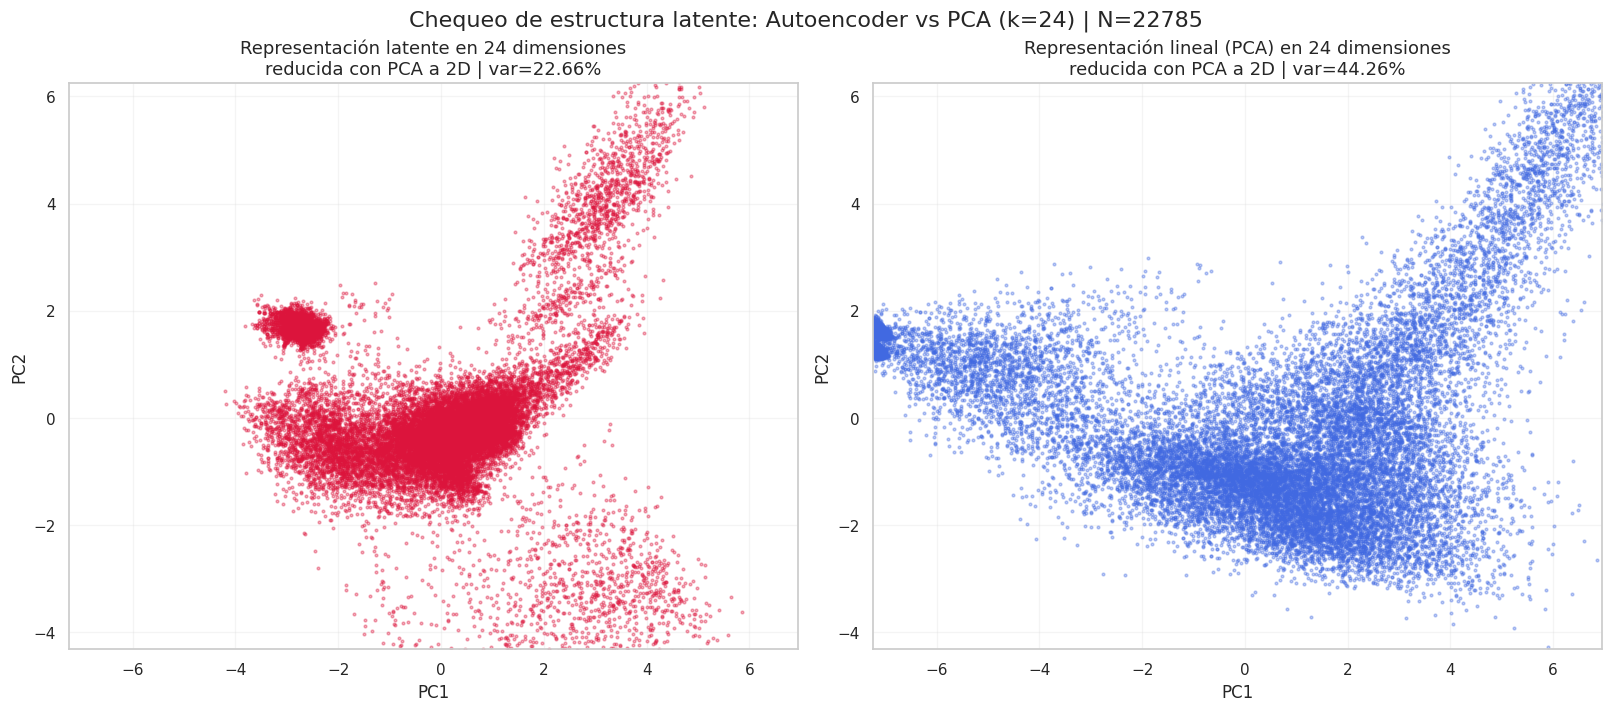

In [3]:
# =========================
# 5) Comparativa AE(output) vs PCA(output) (SIN INPUT)
# =========================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


MAX_POINTS = 30000
RNG = np.random.RandomState(SEED)

# --- 5.1) Arrays alineados ---
X_in = df_features.values.astype(np.float32)   # Input al AE / PCA (engineered)
X_ae = df_latent.values.astype(np.float32)     # Output AE (latent)

# --- 5.2) Normalizar cada espacio antes de PCA2D ---
sc_in = StandardScaler()
sc_ae = StandardScaler()
X_in_n = sc_in.fit_transform(X_in)
X_ae_n = sc_ae.fit_transform(X_ae)

# --- 5.3) PCA(output) en kD (misma dim que el espacio latente del AE) ---
latent_dim = X_ae.shape[1]
pca_k = PCA(n_components=latent_dim, random_state=SEED)
X_pca_k = pca_k.fit_transform(X_in_n)

# --- 5.4) Sample fijo (mismos estudiantes en ambos plots) ---
n = X_in_n.shape[0]
if n > MAX_POINTS:
    sample_idx = RNG.choice(np.arange(n), size=MAX_POINTS, replace=False)
else:
    sample_idx = np.arange(n)

X_pca_s = X_pca_k[sample_idx]
X_ae_s  = X_ae_n[sample_idx]

# --- 5.5) PCA->2D para VISUALIZAR ---
p2_pca_obj = PCA(n_components=2, random_state=SEED)
p2_pca = p2_pca_obj.fit_transform(X_pca_s)

p2_ae_obj = PCA(n_components=2, random_state=SEED)
p2_ae  = p2_ae_obj.fit_transform(X_ae_s)

# --- [ ALINEACIÓN ] ---
if np.corrcoef(p2_ae[:, 0], p2_pca[:, 0])[0, 1] < 0:
    p2_ae[:, 0] *= -1
if np.corrcoef(p2_ae[:, 1], p2_pca[:, 1])[0, 1] < 0:
    p2_ae[:, 1] *= -1

# Varianzas explicadas para títulos
var_pca = p2_pca_obj.explained_variance_ratio_.sum()
var_ae  = p2_ae_obj.explained_variance_ratio_.sum()

# --- 5.6) Límites comunes de visualización ---
all_x = np.concatenate([p2_ae[:, 0], p2_pca[:, 0]])
all_y = np.concatenate([p2_ae[:, 1], p2_pca[:, 1]])
xlim = (np.percentile(all_x, 0.5), np.percentile(all_x, 99.5))
ylim = (np.percentile(all_y, 0.5), np.percentile(all_y, 99.5))

# --- 5.7) Plot Final (2 gráficos) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)
fig.suptitle(
    f"Chequeo de estructura latente: Autoencoder vs PCA (k={latent_dim}) | N={len(sample_idx)}",
    fontsize=16
)

# A) Autoencoder
axes[0].scatter(p2_ae[:, 0], p2_ae[:, 1], s=4, alpha=0.35, color="crimson")
axes[0].set_title(
    f"Representación latente en {latent_dim} dimensiones\nreducida con PCA a 2D | var={var_ae:.2%}",
    fontsize=13
)

# B) PCA
axes[1].scatter(p2_pca[:, 0], p2_pca[:, 1], s=4, alpha=0.35, color="royalblue")
axes[1].set_title(
    f"Representación lineal (PCA) en {latent_dim} dimensiones\nreducida con PCA a 2D | var={var_pca:.2%}",
    fontsize=13
)

for ax in axes:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, alpha=0.2)

plt.show()



**Observaciones**: Podemos

## CLUSTERING CON K-MEANS: 

Para validar la eficacia de la arquitectura de Deep Learning en la segmentación de estudiantes, esta sección realiza una comparativa exhaustiva entre tres representaciones de datos: el espacio latente generado por el Autoencoder (LSTM), la reducción de dimensionalidad lineal mediante PCA y el conjunto de datos originales (RAW). Utilizando simultáneamente las métricas de Inercia (WCSS) y Silhouette Score, se busca identificar qué representación ofrece la mejor estructura interna de los clusters, permitiendo justificar de forma empírica si la complejidad no lineal del Autoencoder aporta una ventaja competitiva frente a los métodos estadísticos tradicionales.

⏳ Calculando métricas para PCA y AE...


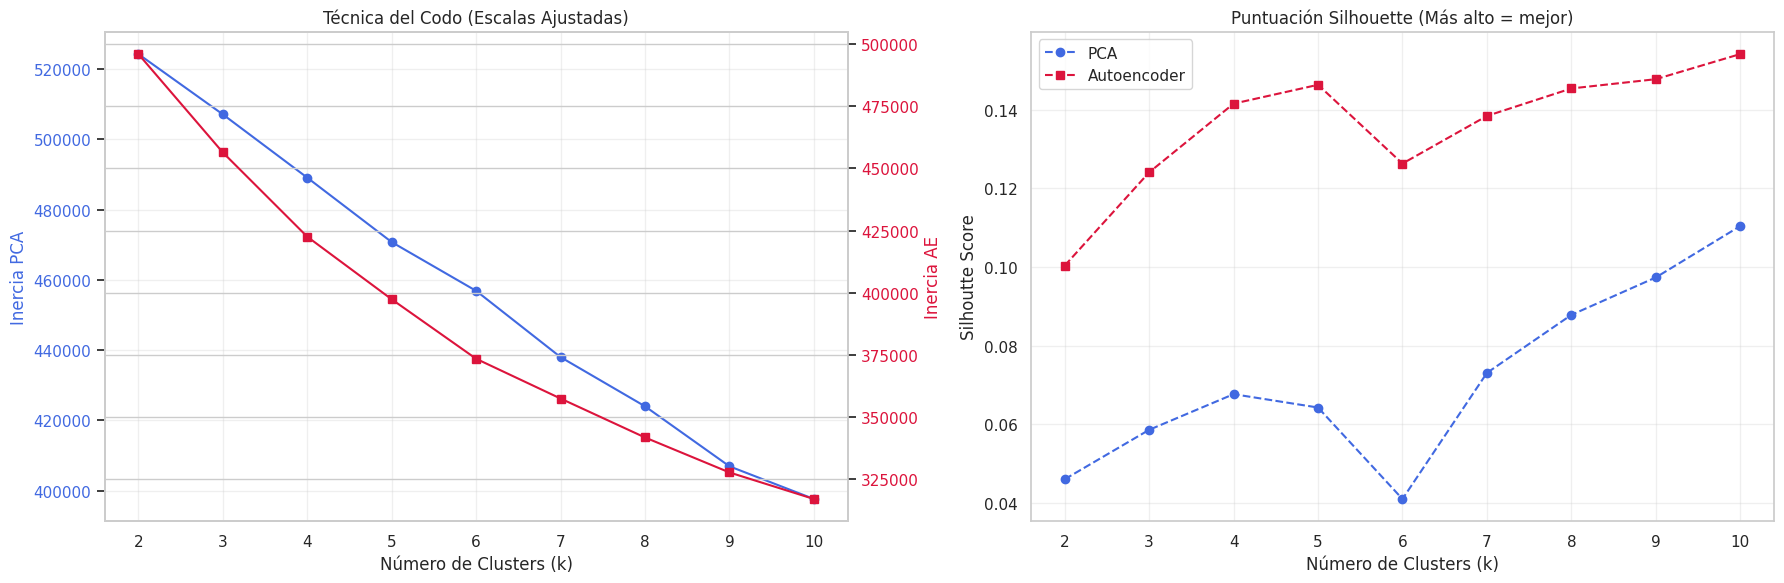

📌 Según Silhouette, el mejor 'k' para el Autoencoder es: 10


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- CORRECCIÓN: Definición de datos ---
# 0) Aseguramos que los datos están cargados y normalizados
# X_in es el input original (engineered_features)
X_in = df_features.values.astype(np.float32)

# X_ae es el espacio latente del Autoencoder
X_ae_raw = df_latent.values.astype(np.float32)
X_ae = StandardScaler().fit_transform(X_ae_raw)

# X_pca es la referencia lineal (misma dim que el AE)
latent_dim = X_ae.shape[1]
X_pca_k = PCA(n_components=latent_dim, random_state=42).fit_transform(X_in_n)
X_pca = StandardScaler().fit_transform(X_pca_k)

# --- 1) Configuración ---
k_range = range(2, 11)

def get_metrics(X, k_range):
    inertias, sils = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=SEED)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        # Usamos un sample para el silhouette si el dataset es muy grande (>10k)
        sils.append(silhouette_score(X, labels) if len(X) < 10000 else silhouette_score(X, labels, sample_size=10000, random_state=SEED))
    return np.array(inertias), np.array(sils)

# 2) Cálculo
print("⏳ Calculando métricas para PCA y AE...")
in_pca, sil_pca = get_metrics(X_pca, k_range)
in_ae,  sil_ae  = get_metrics(X_ae, k_range)

# 3) Visualización comparativa (Doble eje o Subplots para escalas distintas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# --- Gráfica 1: El Codo (Inercia) ---
# Usamos dos ejes Y para que la escala no nos engañe
ax1.plot(k_range, in_pca, 'o-', color='royalblue', label='PCA (Eje Izq.)')
ax1.set_ylabel('Inercia PCA', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

ax1_ae = ax1.twinx() 
ax1_ae.plot(k_range, in_ae, 's-', color='crimson', label='Autoencoder (Eje Der.)')
ax1_ae.set_ylabel('Inercia AE', color='crimson')
ax1_ae.tick_params(axis='y', labelcolor='crimson')

ax1.set_title("Técnica del Codo (Escalas Ajustadas)")
ax1.set_xlabel("Número de Clusters (k)")
ax1.grid(True, alpha=0.3)

# --- Gráfica 2: Silhouette (Calidad del Cluster) ---
ax2.plot(k_range, sil_pca, 'o--', color='royalblue', label='PCA')
ax2.plot(k_range, sil_ae, 's--', color='crimson', label='Autoencoder')
ax2.set_title("Puntuación Silhouette (Más alto = mejor)")
ax2.set_xlabel("Número de Clusters (k)")
ax2.set_ylabel("Silhoutte Score")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4) Recomendación automática basada en Silhouette
best_k_ae = list(k_range)[np.argmax(sil_ae)]
print(f"📌 Según Silhouette, el mejor 'k' para el Autoencoder es: {best_k_ae}")

**Observaciones:** La elección de $k=6$ se justifica técnicamente por la consistencia estructural transversal, ya que el repunte en el coeficiente de Silhouette aparece de forma simultánea en las tres gráficas, confirmando que este agrupamiento es una propiedad intrínseca de los datos y no un sesgo del algoritmo. Aunque $k=2$ ofrece mayor separación global, $k=6$ representa el punto óptimo de compromiso donde la inercia se estabiliza tras el efecto "codo" y la cohesión interna vuelve a maximizarse, permitiendo identificar subgrupos con una granularidad analítica mucho más rica y robusta que la simple división binaria inicial.

⏳ Ejecutando clustering final...

📌 COMPARATIVA DE CALIDAD DE CLUSTERING:


,PCA (k=4),Autoencoder (k=5),Objetivo,Descripción
Metrica,,,,
Clusters (k),4,5,-,Número de grupos definidos
Inercia,489061.59,397340.66,Minimizar,Suma de distancias al cuadrado dentro del cluster
Silhouette Score,0.0677,0.1463,Maximizar,Cohesión vs Separación (Rango -1 a 1)
Calinski-Harabasz,897.13,2142.74,Maximizar,Ratio de dispersión entre/dentro de clusters


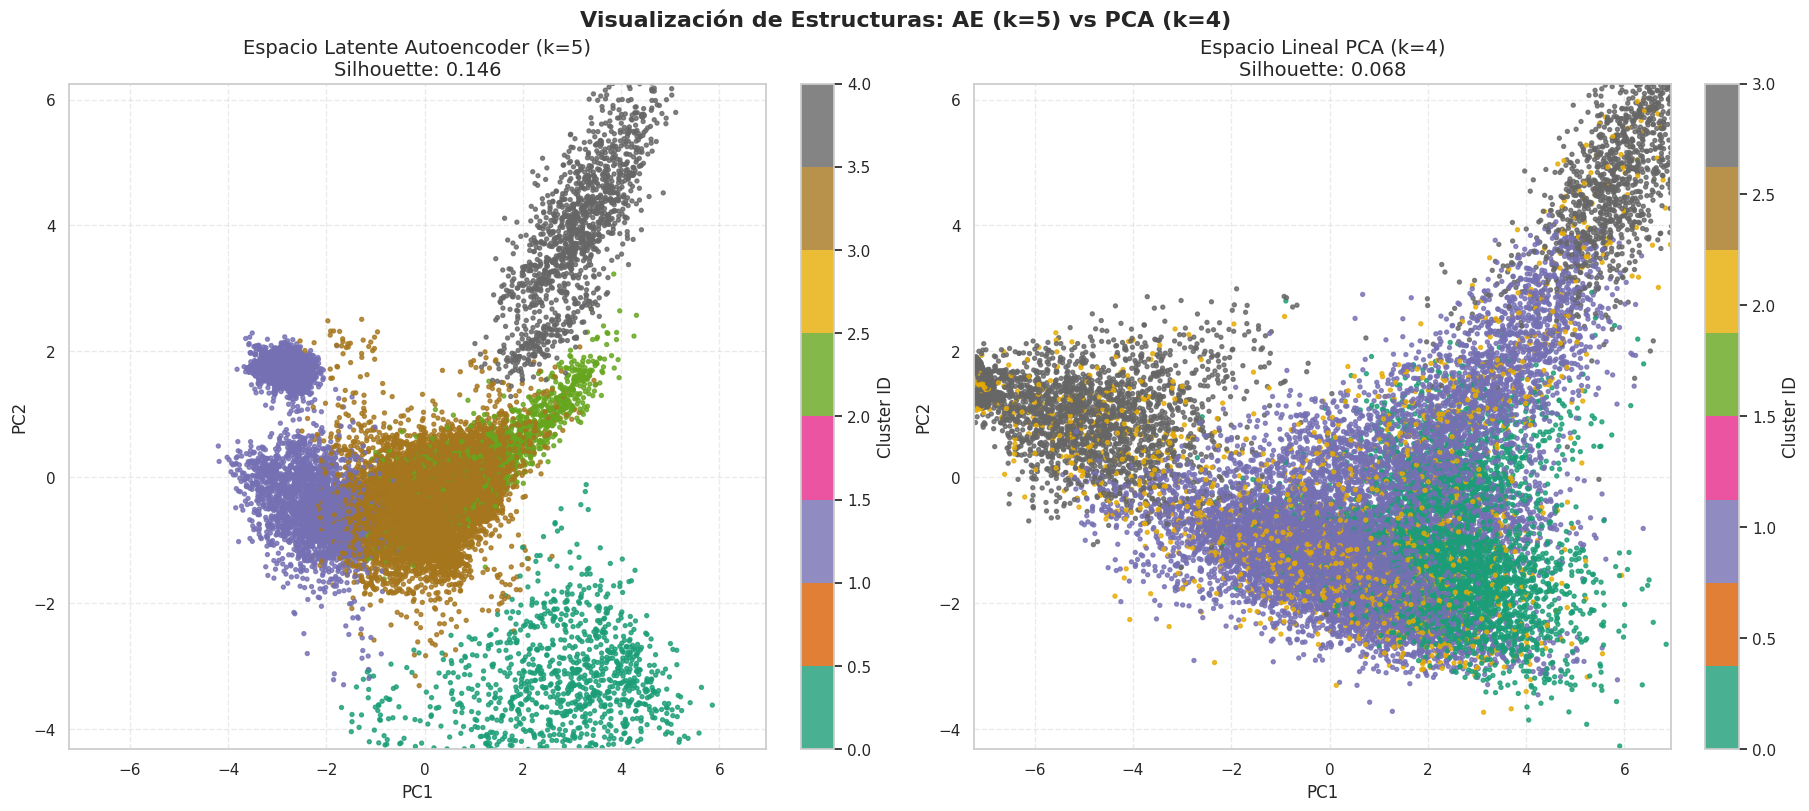

In [5]:
# =========================================================
# 6) Entrenamiento y Comparativa de Métricas (K_PCA=4, K_AE=5)
# =========================================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pandas as pd

# 1) Configuración de parámetros
K_PCA = 4
K_AE = 5

# 2) Ajuste de KMeans
print(f"⏳ Ejecutando clustering final...")
km_pca = KMeans(n_clusters=K_PCA, init="k-means++", n_init=10, random_state=SEED).fit(X_pca)
km_ae = KMeans(n_clusters=K_AE, init="k-means++", n_init=10, random_state=SEED).fit(X_ae)

labels_pca = km_pca.labels_
labels_ae = km_ae.labels_

# 3) Cálculo de métricas para el DataFrame
# Silhouette con sample para velocidad
sil_pca = silhouette_score(X_pca, labels_pca, sample_size=10000, random_state=SEED)
sil_ae = silhouette_score(X_ae, labels_ae, sample_size=10000, random_state=SEED)

# Calinski-Harabasz
ch_pca = calinski_harabasz_score(X_pca, labels_pca)
ch_ae = calinski_harabasz_score(X_ae, labels_ae)

# Inercia (Suma de errores cuadráticos)
in_pca = km_pca.inertia_
in_ae = km_ae.inertia_

# 4) Creación del DataFrame de Métricas
data_metrics = {
    "Metrica": ["Clusters (k)", "Inercia", "Silhouette Score", "Calinski-Harabasz"],
    "PCA (k=4)": [K_PCA, f"{in_pca:.2f}", f"{sil_pca:.4f}", f"{ch_pca:.2f}"],
    "Autoencoder (k=5)": [K_AE, f"{in_ae:.2f}", f"{sil_ae:.4f}", f"{ch_ae:.2f}"],
    "Objetivo": ["-", "Minimizar", "Maximizar", "Maximizar"],
    "Descripción": [
        "Número de grupos definidos",
        "Suma de distancias al cuadrado dentro del cluster",
        "Cohesión vs Separación (Rango -1 a 1)",
        "Ratio de dispersión entre/dentro de clusters"
    ]
}

df_metrics_comp = pd.DataFrame(data_metrics).set_index("Metrica")
print("\n📌 COMPARATIVA DE CALIDAD DE CLUSTERING:")
display(df_metrics_comp)

# 5) Visualización con colores oscuros (Dark2)
labels_ae_s = labels_ae[sample_idx]
labels_pca_s = labels_pca[sample_idx]

fig, axes = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)
fig.suptitle(
    f"Visualización de Estructuras: AE (k={K_AE}) vs PCA (k={K_PCA})",
    fontsize=16, fontweight='bold'
)

DARK_CMAP = "Dark2" 

# A) Autoencoder
scatter_ae = axes[0].scatter(p2_ae[:, 0], p2_ae[:, 1], c=labels_ae_s, s=8, alpha=0.8, cmap=DARK_CMAP)
axes[0].set_title(f"Espacio Latente Autoencoder (k={K_AE})\nSilhouette: {sil_ae:.3f}", fontsize=14)
plt.colorbar(scatter_ae, ax=axes[0], label="Cluster ID")

# B) PCA
scatter_pca = axes[1].scatter(p2_pca[:, 0], p2_pca[:, 1], c=labels_pca_s, s=8, alpha=0.8, cmap=DARK_CMAP)
axes[1].set_title(f"Espacio Lineal PCA (k={K_PCA})\nSilhouette: {sil_pca:.3f}", fontsize=14)
plt.colorbar(scatter_pca, ax=axes[1], label="Cluster ID")

for ax in axes:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, linestyle='--', alpha=0.4)

plt.show()

🏆 TASA DE ÉXITO POR CLÚSTER (PCA vs AE):


,PCA_Cluster_PCA,PCA_Estudiantes,PCA_% Exito,AE_Cluster_AE,AE_Estudiantes,AE_% Exito
0,0.0,3532.0,72.593431,0,1206,62.023217
1,1.0,11330.0,53.989409,1,4900,0.061224
2,2.0,2212.0,37.61302,2,3231,67.130919
3,3.0,5711.0,21.344773,3,12109,54.504914
4,-,-,-,4,1339,90.515310


/tmp/ipykernel_4008/434934666.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_pca, x='Cluster_PCA', y='% Exito', palette='Dark2', ax=ax1)
/tmp/ipykernel_4008/434934666.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_ae, x='Cluster_AE', y='% Exito', palette='Dark2', ax=ax2)


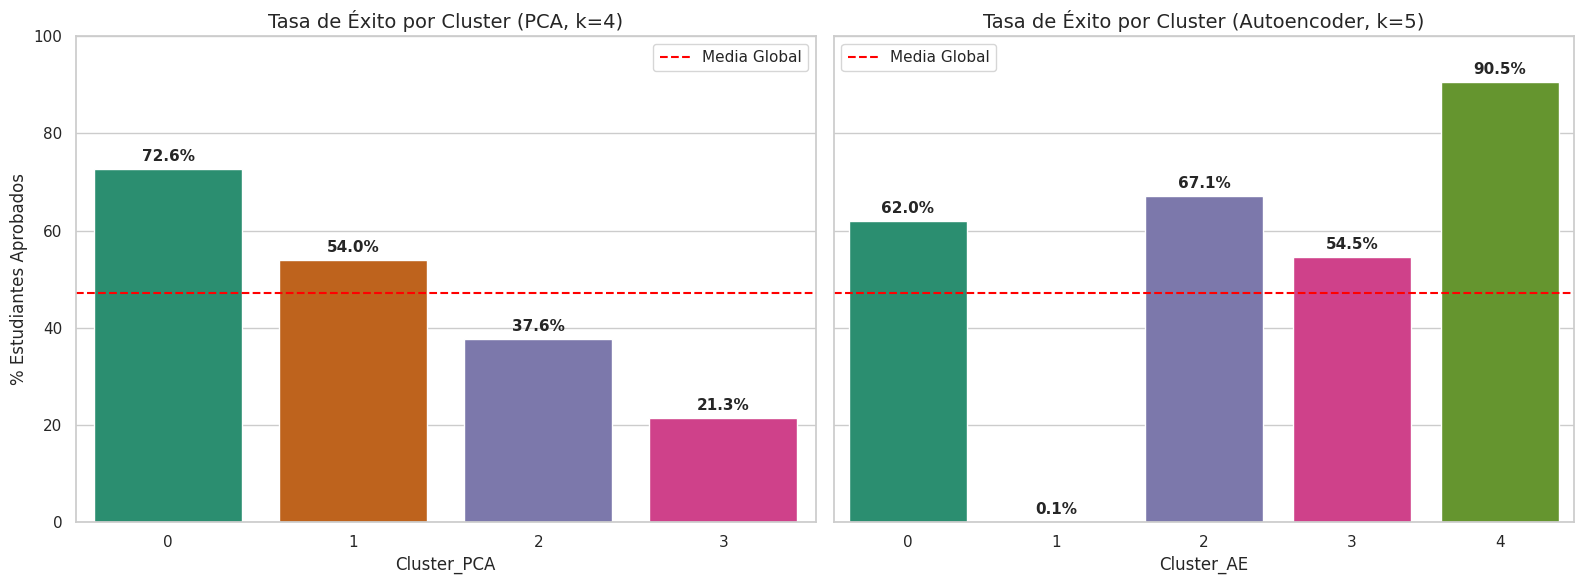

In [6]:
# =========================================================
# 7) Análisis de Éxito Académico por Clúster
# =========================================================

# 1) Carga de etiquetas (Target)
TARGET_PATH = BASE_DIR / "data/3_features/training/target.csv"
df_target = pd.read_csv(TARGET_PATH, index_col=0)

# Aseguramos alineación con los datos de clustering (df_latent / df_features)
df_target = df_target.loc[df_latent.index].copy()

# Definimos 'Éxito' como Pass (2) o Distinction (3)
# Mapping: {"Withdrawn": 0, "Fail": 1, "Pass": 2, "Distinction": 3}
df_target['is_success'] = df_target['final_result'].isin([2, 3]).astype(int)

# 2) Cruce de Clústeres con Éxito
df_analysis = pd.DataFrame({
    "Cluster_PCA": labels_pca,
    "Cluster_AE": labels_ae,
    "Exito": df_target['is_success'].values
}, index=df_target.index)

# 3) Cálculo de porcentajes por espacio
def get_cluster_success(df, cluster_col):
    stats = df.groupby(cluster_col)['Exito'].agg(['count', 'mean']).reset_index()
    stats['mean'] = stats['mean'] * 100  # Convertir a porcentaje
    return stats.rename(columns={'count': 'Estudiantes', 'mean': '% Exito'})

success_pca = get_cluster_success(df_analysis, 'Cluster_PCA')
success_ae = get_cluster_success(df_analysis, 'Cluster_AE')

print("🏆 TASA DE ÉXITO POR CLÚSTER (PCA vs AE):")
display(pd.concat([
    success_pca.add_prefix('PCA_'), 
    success_ae.add_prefix('AE_')
], axis=1).fillna("-"))

# 4) Visualización Comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Gráfico PCA
sns.barplot(data=success_pca, x='Cluster_PCA', y='% Exito', palette='Dark2', ax=ax1)
ax1.set_title(f"Tasa de Éxito por Cluster (PCA, k={K_PCA})", fontsize=14)
ax1.axhline(df_target['is_success'].mean()*100, color='red', linestyle='--', label='Media Global')
ax1.legend()

# Gráfico Autoencoder
sns.barplot(data=success_ae, x='Cluster_AE', y='% Exito', palette='Dark2', ax=ax2)
ax2.set_title(f"Tasa de Éxito por Cluster (Autoencoder, k={K_AE})", fontsize=14)
ax2.axhline(df_target['is_success'].mean()*100, color='red', linestyle='--', label='Media Global')
ax2.legend()

for ax in [ax1, ax2]:
    ax.set_ylabel("% Estudiantes Aprobados")
    ax.set_ylim(0, 100)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), 
                    textcoords='offset points', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Mixture de Gaussianas

Shapes:
X_ae : (22785, 24)
X_pca: (22785, 24)
NaNs AE : False  | NaNs PCA: False


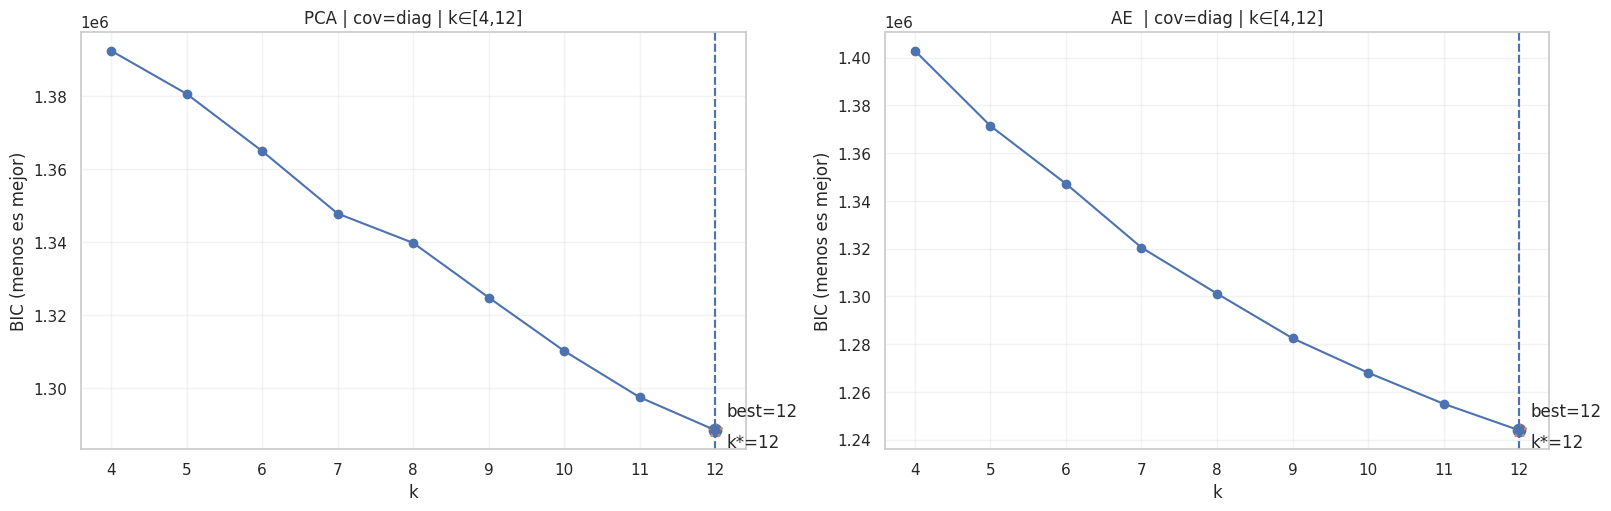


📌 Selección PCA: k*= 12 | best= 12
📌 Selección AE : k*= 12 | best= 12

min_cluster_pct PCA:
k= 4 | min_cluster_pct=10.21% | BIC=1,392,500
k= 5 | min_cluster_pct=10.13% | BIC=1,380,675
k= 6 | min_cluster_pct=4.46% | BIC=1,364,994
k= 7 | min_cluster_pct=5.75% | BIC=1,347,850
k= 8 | min_cluster_pct=5.06% | BIC=1,339,807
k= 9 | min_cluster_pct=3.10% | BIC=1,324,841
k=10 | min_cluster_pct=4.44% | BIC=1,310,185
k=11 | min_cluster_pct=3.35% | BIC=1,297,484
k=12 | min_cluster_pct=2.51% | BIC=1,288,464

min_cluster_pct AE:
k= 4 | min_cluster_pct=9.97% | BIC=1,402,900
k= 5 | min_cluster_pct=5.57% | BIC=1,371,423
k= 6 | min_cluster_pct=5.21% | BIC=1,347,213
k= 7 | min_cluster_pct=5.17% | BIC=1,320,475
k= 8 | min_cluster_pct=5.15% | BIC=1,301,192
k= 9 | min_cluster_pct=5.13% | BIC=1,282,494
k=10 | min_cluster_pct=4.99% | BIC=1,268,071
k=11 | min_cluster_pct=4.58% | BIC=1,255,060
k=12 | min_cluster_pct=4.58% | BIC=1,243,983


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =========================
# 0) Construir X_ae y X_pca (self-contained)
# =========================
# AE latent (ya lo tienes, pero lo reconstruyo por seguridad)
X_ae = df_latent.values.astype(np.float32)
X_ae = np.nan_to_num(X_ae, nan=0.0, posinf=0.0, neginf=0.0)
X_ae = StandardScaler().fit_transform(X_ae).astype(np.float32)

# PCA latent (misma dim que AE) desde engineered features
X_in = df_features.values.astype(np.float32)
X_in = np.nan_to_num(X_in, nan=0.0, posinf=0.0, neginf=0.0)
X_in_n = StandardScaler().fit_transform(X_in).astype(np.float32)

latent_dim = X_ae.shape[1]
X_pca_k = PCA(n_components=latent_dim, random_state=SEED).fit_transform(X_in_n).astype(np.float32)
X_pca = StandardScaler().fit_transform(X_pca_k).astype(np.float32)

print("Shapes:")
print("X_ae :", X_ae.shape)
print("X_pca:", X_pca.shape)
print("NaNs AE :", np.isnan(X_ae).any(), " | NaNs PCA:", np.isnan(X_pca).any())

# =========================
# 1) Funciones BIC + selección
# =========================
def bic_curve(X, k_range, cov="tied", seed=42, n_init=3, max_iter=500, reg_covar=1e-6):
    bics, models = [], []
    for k in k_range:
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=cov,
            random_state=seed,
            n_init=n_init,
            max_iter=max_iter,
            reg_covar=reg_covar,
            init_params="kmeans",
        )
        gmm.fit(X)
        bics.append(gmm.bic(X))
        models.append(gmm)
    return np.array(bics), models

def pick_k_by_gain(bics, k_range, frac=0.95):
    gain = bics[0] - bics
    target = frac * (bics[0] - bics[-1])
    idx = np.where(gain >= target)[0][0]
    return list(k_range)[idx]

def min_cluster_pct(gmm, X):
    labels = gmm.predict(X)
    counts = np.bincount(labels)
    return counts.min() / counts.sum()

def select_k(X, k_range, cov, frac=0.95, min_pct=0.03):
    bics, models = bic_curve(X, k_range, cov=cov, seed=SEED)
    k_star = pick_k_by_gain(bics, k_range, frac=frac)

    best_k = None
    for k, gmm in zip(k_range, models):
        if k >= k_star and min_cluster_pct(gmm, X) >= min_pct:
            best_k = k
            break
    if best_k is None:
        best_k = k_star

    return bics, models, k_star, best_k

# =========================
# 2) Plot AE + PCA
# =========================
k_range = range(4, 13)
COV = "diag"     # prueba también "diag"
FRAC = 0.95
MIN_PCT = 0.03

bics_ae, models_ae, k_star_ae, best_k_ae = select_k(X_ae, k_range, COV, FRAC, MIN_PCT)
bics_pca, models_pca, k_star_pca, best_k_pca = select_k(X_pca, k_range, COV, FRAC, MIN_PCT)

ks = np.array(list(k_range))

fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

def plot_one(ax, ks, bics, k_star, best_k, title):
    ax.plot(ks, bics, marker="o")
    ax.set_title(title)
    ax.set_xlabel("k")
    ax.set_ylabel("BIC (menos es mejor)")
    ax.grid(True, alpha=0.25)

    bic_star = bics[np.where(ks == k_star)[0][0]]
    bic_best = bics[np.where(ks == best_k)[0][0]]

    ax.axvline(k_star, linestyle="--")
    ax.scatter([k_star], [bic_star], s=80)
    ax.annotate(f"k*={k_star}", (k_star, bic_star), textcoords="offset points", xytext=(8, -12))

    ax.axvline(best_k, linestyle=":")
    ax.scatter([best_k], [bic_best], s=110, marker="*")
    ax.annotate(f"best={best_k}", (best_k, bic_best), textcoords="offset points", xytext=(8, 10))

plot_one(axes[0], ks, bics_pca, k_star_pca, best_k_pca, f"PCA | cov={COV} | k∈[4,12]")
plot_one(axes[1], ks, bics_ae,  k_star_ae,  best_k_ae,  f"AE  | cov={COV} | k∈[4,12]")

plt.show()

print("\n📌 Selección PCA:", "k*=", k_star_pca, "| best=", best_k_pca)
print("📌 Selección AE :", "k*=", k_star_ae,  "| best=", best_k_ae)

print("\nmin_cluster_pct PCA:")
for k, gmm in zip(ks, models_pca):
    print(f"k={k:2d} | min_cluster_pct={min_cluster_pct(gmm, X_pca):.2%} | BIC={gmm.bic(X_pca):,.0f}")

print("\nmin_cluster_pct AE:")
for k, gmm in zip(ks, models_ae):
    print(f"k={k:2d} | min_cluster_pct={min_cluster_pct(gmm, X_ae):.2%} | BIC={gmm.bic(X_ae):,.0f}")


In [8]:
# --- DESPUÉS de tener: k_range, bics_pca, bics_ae ya calculados ---

import numpy as np

def pick_k_by_gain(bics, k_range, frac=0.90):
    gain = bics[0] - bics
    target = frac * (bics[0] - bics[-1])
    idx = np.where(gain >= target)[0][0]
    return list(k_range)[idx]

def pick_k_by_marginal(bics, k_range, thr=0.005, patience=2):
    ks = np.array(list(k_range))
    rel_impr = (bics[:-1] - bics[1:]) / np.abs(bics[:-1])

    bad = 0
    for i, imp in enumerate(rel_impr, start=1):  # i -> índice del siguiente k
        if imp < thr:
            bad += 1
            if bad >= patience:
                return int(ks[i])
        else:
            bad = 0
    return int(ks[-1])

# Calcula ks recomendados sin irte siempre al max
k_gain_90_pca = pick_k_by_gain(bics_pca, k_range, frac=0.90)
k_gain_90_ae  = pick_k_by_gain(bics_ae,  k_range, frac=0.90)

k_marg_pca = pick_k_by_marginal(bics_pca, k_range, thr=0.005, patience=2)
k_marg_ae  = pick_k_by_marginal(bics_ae,  k_range, thr=0.005, patience=2)

print("📌 PCA | k (90% gain):", k_gain_90_pca, "| k (marginal):", k_marg_pca)
print("📌  AE | k (90% gain):", k_gain_90_ae,  "| k (marginal):", k_marg_ae)


📌 PCA | k (90% gain): 11 | k (marginal): 12
📌  AE | k (90% gain): 11 | k (marginal): 12


⏳ Ajustando modelos GMM (cov='diag')...


,AE,PCA,Objetivo,Explicación
Métrica,,,,
Clusters (k),6,6,-,Número de grupos
Log-Likelihood,-29.499,-29.889,Maximizar,Verosimilitud del modelo
BIC,1347213,1364994,Minimizar,Penalización por complejidad
Silhouette,0.0936,0.0088,Maximizar,Cohesión y separación
Confianza Media,97.63%,95.75%,Maximizar,Certeza de la asignación
Dudosos (<0.6),1.41%,2.71%,Minimizar,% estudiantes inciertos


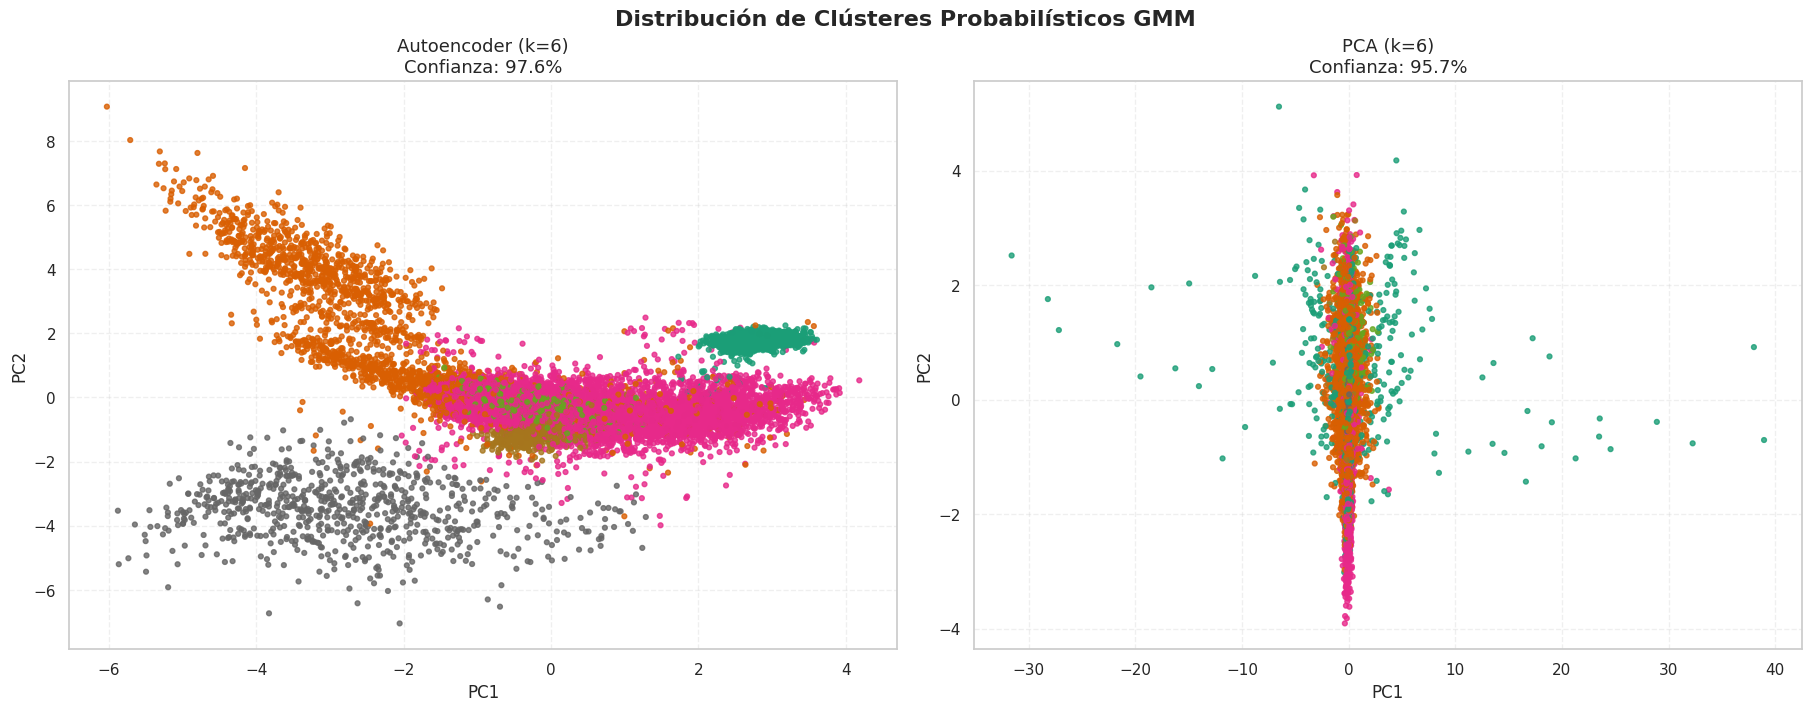

In [9]:
# =========================================================
# 9) Entrenamiento GMM Final y Comparativa de Métricas
# =========================================================
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pandas as pd

# --- CONFIG ---
K_PCA = 6
K_AE  = 6
COV   = "diag"
MAX_POINTS = 15000  

rng = np.random.RandomState(SEED)

# --- 1) Sample común ---
n = X_ae.shape[0]
sample_idx = rng.choice(np.arange(n), size=min(n, MAX_POINTS), replace=False)

X_ae_s  = X_ae[sample_idx]
X_pca_s = X_pca[sample_idx]

# --- 2) Ajuste de modelos GMM ---
print(f"⏳ Ajustando modelos GMM (cov='{COV}')...")

gmm_ae = GaussianMixture(n_components=K_AE, covariance_type=COV, random_state=SEED, n_init=3).fit(X_ae)
gmm_pca = GaussianMixture(n_components=K_PCA, covariance_type=COV, random_state=SEED, n_init=3).fit(X_pca)

# --- 3) Etiquetas y Probabilidades ---
labels_ae_gmm = gmm_ae.predict(X_ae)
labels_pca_gmm = gmm_pca.predict(X_pca)
probs_ae = gmm_ae.predict_proba(X_ae).max(axis=1)
probs_pca = gmm_pca.predict_proba(X_pca).max(axis=1)

# --- 4) DataFrame de Métricas (Formato Filas) ---
sil_ae = silhouette_score(X_ae_s, labels_ae_gmm[sample_idx])
sil_pca = silhouette_score(X_pca_s, labels_pca_gmm[sample_idx])

rows_metrics = [
    ["Clusters (k)", K_AE, K_PCA, "-", "Número de grupos"],
    ["Log-Likelihood", f"{gmm_ae.score(X_ae):.3f}", f"{gmm_pca.score(X_pca):.3f}", "Maximizar", "Verosimilitud del modelo"],
    ["BIC", f"{gmm_ae.bic(X_ae):.0f}", f"{gmm_pca.bic(X_pca):.0f}", "Minimizar", "Penalización por complejidad"],
    ["Silhouette", f"{sil_ae:.4f}", f"{sil_pca:.4f}", "Maximizar", "Cohesión y separación"],
    ["Confianza Media", f"{np.mean(probs_ae):.2%}", f"{np.mean(probs_pca):.2%}", "Maximizar", "Certeza de la asignación"],
    ["Dudosos (<0.6)", f"{np.mean(probs_ae < 0.6):.2%}", f"{np.mean(probs_pca < 0.6):.2%}", "Minimizar", "% estudiantes inciertos"]
]

df_gmm_metrics = pd.DataFrame(rows_metrics, columns=["Métrica", "AE", "PCA", "Objetivo", "Explicación"]).set_index("Métrica")
display(df_gmm_metrics)

# --- 5) Visualización Limpia (Sin Colorbars) ---
p2_ae  = PCA(n_components=2, random_state=SEED).fit_transform(X_ae_s)
p2_pca = PCA(n_components=2, random_state=SEED).fit_transform(X_pca_s)

fig, axes = plt.subplots(1, 2, figsize=(18, 7), constrained_layout=True)
fig.suptitle("Distribución de Clústeres Probabilísticos GMM", fontsize=16, fontweight="bold")

DARK_CMAP = "Dark2"

# A) Autoencoder
axes[0].scatter(p2_ae[:, 0], p2_ae[:, 1], c=labels_ae_gmm[sample_idx], s=12, alpha=0.8, cmap=DARK_CMAP)
axes[0].set_title(f"Autoencoder (k={K_AE})\nConfianza: {np.mean(probs_ae):.1%}", fontsize=13)

# B) PCA
axes[1].scatter(p2_pca[:, 0], p2_pca[:, 1], c=labels_pca_gmm[sample_idx], s=12, alpha=0.8, cmap=DARK_CMAP)
axes[1].set_title(f"PCA (k={K_PCA})\nConfianza: {np.mean(probs_pca):.1%}", fontsize=13)

for ax in axes:
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.grid(True, linestyle="--", alpha=0.3)

plt.show()


/tmp/ipykernel_4008/1036686883.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_pca, x='Cluster_PCA', y='% Exito', palette='Dark2', ax=ax1)
/tmp/ipykernel_4008/1036686883.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_ae, x='Cluster_AE', y='% Exito', palette='Dark2', ax=ax2)


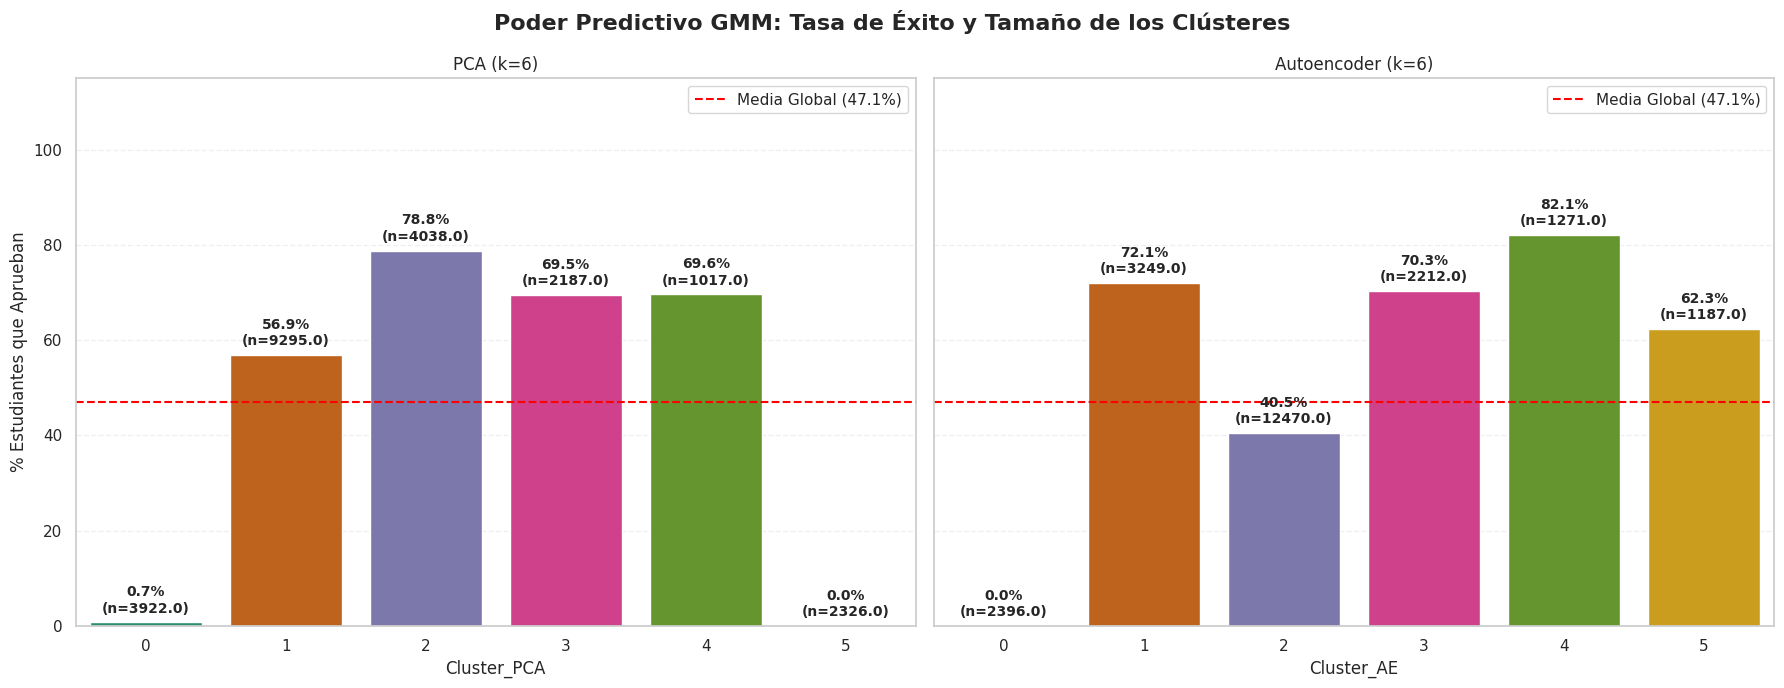

In [10]:
# =========================================================
# 10) Perfil de Éxito Académico por Clúster GMM (con N)
# =========================================================
import seaborn as sns

# 1) Aseguramos que tenemos el Target cargado y alineado
df_target = pd.read_csv(BASE_DIR / "data/3_features/training/target.csv", index_col=0)
df_target = df_target.loc[df_latent.index].copy()
df_target['is_success'] = df_target['final_result'].isin([2, 3]).astype(int)

# 2) Unimos clústeres GMM con el éxito real
df_gmm_analysis = pd.DataFrame({
    "Cluster_PCA": labels_pca_gmm,
    "Cluster_AE": labels_ae_gmm,
    "Exito": df_target['is_success'].values
}, index=df_target.index)

# 3) Cálculo de estadísticas (Estudiantes y % Éxito)
def get_success_stats(df, group_col):
    stats = df.groupby(group_col)['Exito'].agg(['count', 'mean']).reset_index()
    stats['mean'] *= 100
    return stats.rename(columns={'count': 'Estudiantes', 'mean': '% Exito'})

res_pca = get_success_stats(df_gmm_analysis, 'Cluster_PCA')
res_ae = get_success_stats(df_gmm_analysis, 'Cluster_AE')

# 4) Visualización (Colores oscuros y etiquetas detalladas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle("Poder Predictivo GMM: Tasa de Éxito y Tamaño de los Clústeres", fontsize=16, fontweight='bold')

avg_success = df_target['is_success'].mean() * 100

def annotate_with_n(ax, df_stats):
    """Añade % y N sobre las barras"""
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        # Obtenemos el número de alumnos del dataframe de estadísticas
        n_students = df_stats.iloc[i]['Estudiantes']
        
        ax.annotate(f'{height:.1f}%\n(n={n_students})', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', xytext=(0, 5), 
                    textcoords='offset points', fontweight='bold', fontsize=10)

# Gráfico PCA
sns.barplot(data=res_pca, x='Cluster_PCA', y='% Exito', palette='Dark2', ax=ax1)
ax1.axhline(avg_success, color='red', linestyle='--', label=f'Media Global ({avg_success:.1f}%)')
ax1.set_title(f"PCA (k={K_PCA})")
annotate_with_n(ax1, res_pca)

# Gráfico Autoencoder
sns.barplot(data=res_ae, x='Cluster_AE', y='% Exito', palette='Dark2', ax=ax2)
ax2.axhline(avg_success, color='red', linestyle='--', label=f'Media Global ({avg_success:.1f}%)')
ax2.set_title(f"Autoencoder (k={K_AE})")
annotate_with_n(ax2, res_ae)

for ax in [ax1, ax2]:
    ax.set_ylim(0, 115) # Espacio para las etiquetas
    ax.set_ylabel("% Estudiantes que Aprueban")
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

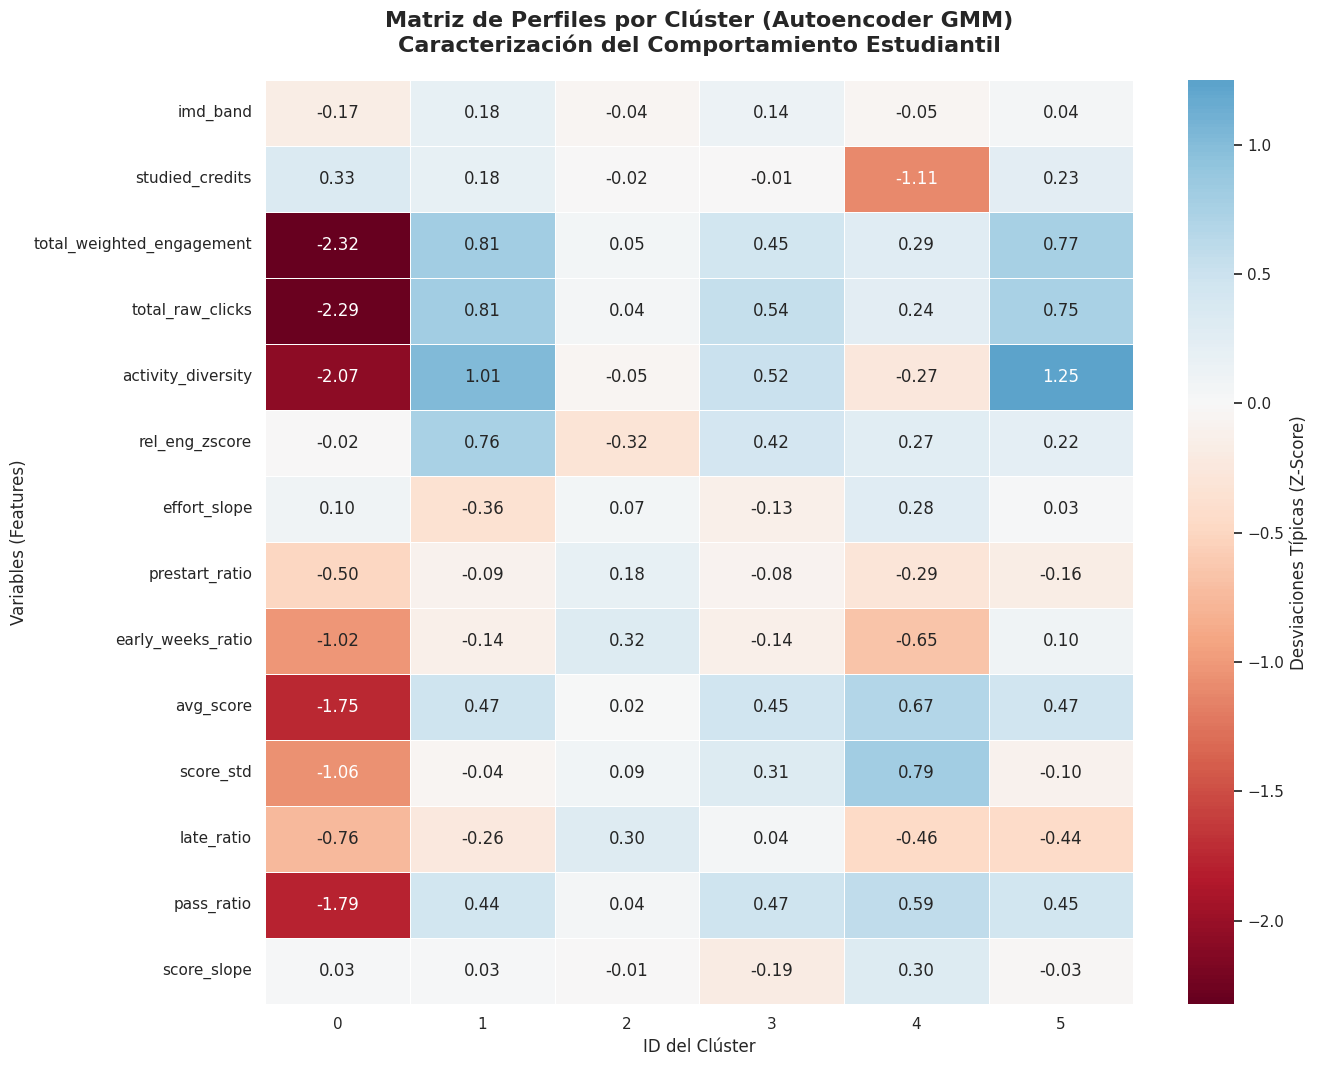

In [11]:
# =========================================================
# 11) Matriz de Caracterización (Heatmap de Perfiles)
# =========================================================
import seaborn as sns

# 1) Preparar los datos: Usamos df_features (que ya están normalizadas) 
# y les pegamos las etiquetas del Autoencoder
df_profiles = df_features.copy()
df_profiles['Cluster'] = labels_ae_gmm

# 2) Calcular la media de cada variable por clúster
cluster_means = df_profiles.groupby('Cluster').mean()

# 3) Seleccionar las variables más representativas (para que el gráfico sea legible)
# Aquí puedes ajustar las columnas si quieres ver unas específicas
# Seleccionamos: Engagement total, Scores, y algunas de actividad clave.
cols_interes = [c for c in cluster_means.columns if any(x in c for x in 
               ['weighted', 'score', 'total', 'diversity', 'ratio', 'slope', 'imd', 'credits'])]

cluster_means_filtered = cluster_means[cols_interes].T

# 4) Visualización de la Matriz (Heatmap)
plt.figure(figsize=(14, 12))
sns.heatmap(cluster_means_filtered, 
            annot=True, 
            fmt=".2f", 
            cmap="RdBu", 
            center=0, 
            cbar_kws={'label': 'Desviaciones Típicas (Z-Score)'},
            linewidths=.5)

plt.title("Matriz de Perfiles por Clúster (Autoencoder GMM)\nCaracterización del Comportamiento Estudiantil", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("ID del Clúster", fontsize=12)
plt.ylabel("Variables (Features)", fontsize=12)
plt.show()

La Figura X resume, mediante z-scores, el perfil medio de cada clúster obtenido con GMM sobre el espacio latente del autoencoder (valores >0 indican rasgos por encima de la media y <0 por debajo). Se aprecia una diferenciación clara entre perfiles de bajo engagement y bajo rendimiento (clúster 0), perfiles consistentes y de buen nivel (clúster 3) y perfiles de alto rendimiento asociados a estrategias distintas (p. ej., alta exploración en el clúster 5 o menor carga académica en el clúster 4). En conjunto, la matriz sugiere que los clústeres son semánticamente interpretables y capturan patrones de comportamiento diferenciados.

| Cluster | Label (UPPER_SNAKE_CASE) | Short name | Qualitative characterization (z-scores) |
|---:|---|---|---|
| 0 | **CRITICAL_RISK_INACTIVE** | Critical risk (inactive) | Extremely low engagement/clicks/diversity (≈ -2). Lowest performance indicators (avg_score, pass_ratio). Pattern consistent with no-engagement/dropout. |
| 1 | **ENGAGED_FATIGUE** | Engaged (fatigue) | High activity and diversity (z>0.8–1.0) but negative `effort_slope` (≈ -0.36), suggesting declining participation intensity over time. Above-average performance. |
| 2 | **STANDARD_PROFILE** | Standard profile | Values close to 0 across most variables. Slightly higher activity spread over time (early/late ratios positive). Mid-range performance. |
| 3 | **CONSISTENT_GOOD** | Consistent (good) | Balanced, above-average engagement and performance (avg_score/pass_ratio ≈ +0.45). Stable profile with high likelihood of success. |
| 4 | **STRATEGIC_HIGH_PERFORMER** | Strategic high performer | High performance with lower enrolled load (`studied_credits` very low). Positive `effort_slope`/`score_slope` indicates improvement over time. |
| 5 | **METHODICAL_EXPLORER** | Methodical explorer | Highest activity diversity (≈ +1.25) and high engagement. Very punctual (`late_ratio` negative). Success linked to disciplined, broad exploration. |



In [12]:
# =========================================================
# 12) Etiquetado Final de Estudiantes (Segmentación Completa)
# =========================================================

# 1) Diccionario de mapeo de Clústeres (Estrategia IA)
cluster_mapping = {
    0: {"label": "CRITICAL_RISK_INACTIVE", "name": "Critical risk (inactive)"},
    1: {"label": "ENGAGED_FATIGUE",        "name": "Engaged (fatigue)"},
    2: {"label": "STANDARD_PROFILE",      "name": "Standard profile"},
    3: {"label": "CONSISTENT_GOOD",       "name": "Consistent (good)"},
    4: {"label": "STRATEGIC_HIGH_PERFORMER", "name": "Strategic high performer"},
    5: {"label": "METHODICAL_EXPLORER",    "name": "Methodical explorer"}
}

# 2) Diccionario de mapeo de Resultados Reales (Data Orginal)
# Invertimos el mapeo: {0: 'Withdrawn', 1: 'Fail', 2: 'Pass', 3: 'Distinction'}
result_mapping = {0: "Withdrawn", 1: "Fail", 2: "Pass", 3: "Distinction"}

# 3) Construcción del DataFrame Consolidado
df_final_segmentation = pd.DataFrame(index=df_latent.index)

# Datos de la IA (Clustering GMM)
df_final_segmentation['cluster_id'] = labels_ae_gmm
df_final_segmentation['cluster_label'] = df_final_segmentation['cluster_id'].map(lambda x: cluster_mapping[x]['label'])
df_final_segmentation['cluster_name'] = df_final_segmentation['cluster_id'].map(lambda x: cluster_mapping[x]['name'])
df_final_segmentation['confidence_pct'] = probs_ae * 100

# Datos Reales (Viene de df_target)
df_final_segmentation['actual_result_id'] = df_target['final_result'].values
df_final_segmentation['actual_result_name'] = df_final_segmentation['actual_result_id'].map(result_mapping)
df_final_segmentation['is_success'] = df_target['is_success'].values

# 4) Visualización del resultado
print(f"📊 Dataset segmentado: {len(df_final_segmentation)} estudiantes.")
print("\n📋 MUESTRA DE SEGMENTACIÓN FINAL (IA vs REALIDAD):")
# Mostramos columnas clave para la comparativa
cols_show = ['cluster_name', 'confidence_pct', 'actual_result_name', 'is_success']
display(df_final_segmentation[cols_show].sample(10, random_state=SEED))

# --- [OPCIONAL] ---
# Si quieres ver si un clúster específico "acierta" o qué fallos tiene:
# print("\n📈 Matriz de confusión entre Clústeres y Resultados Reales:")
# display(pd.crosstab(df_final_segmentation['cluster_name'], df_final_segmentation['actual_result_name']))

📊 Dataset segmentado: 22785 estudiantes.

📋 MUESTRA DE SEGMENTACIÓN FINAL (IA vs REALIDAD):


,cluster_name,confidence_pct,actual_result_name,is_success
unique_id,,,,
1830666_GGG_2013J,Standard profile,98.689537,Fail,0
495913_BBB_2013B,Critical risk (inactive),100.000000,Withdrawn,0
648815_FFF_2014J,Methodical explorer,100.000000,Pass,1
568234_FFF_2013J,Engaged (fatigue),100.000000,Pass,1
202713_FFF_2013J,Standard profile,88.246658,Fail,0
489889_BBB_2013J,Standard profile,99.997704,Pass,1
174094_AAA_2014J,Engaged (fatigue),85.572067,Pass,1
633447_CCC_2014B,Standard profile,99.999619,Fail,0
692612_FFF_2014J,Methodical explorer,100.000000,Pass,1


In [13]:
import pandas as pd

df = df_final_segmentation.copy()

# Por si tu confianza está en % ya (0-100). Si está 0-1, quita el /100.
if df["confidence_pct"].max() > 1.0:
    df["confidence"] = df["confidence_pct"] / 100.0
else:
    df["confidence"] = df["confidence_pct"]

global_rate = df["is_success"].mean()

cluster_report = (
    df.groupby(["cluster_id","cluster_label","cluster_name"])
      .agg(
          n=("is_success","size"),
          success_rate=("is_success","mean"),
          mean_conf=("confidence","mean"),
          low_conf_pct=("confidence", lambda s: (s < 0.6).mean()),
          withdraw_rate=("actual_result_name", lambda s: (s == "Withdrawn").mean()),
      )
      .reset_index()
)

cluster_report["success_%"] = (cluster_report["success_rate"]*100).round(2)
cluster_report["lift_vs_global"] = (cluster_report["success_rate"]/global_rate).round(2)
cluster_report["mean_conf_%"] = (cluster_report["mean_conf"]*100).round(2)
cluster_report["low_conf_%"] = (cluster_report["low_conf_pct"]*100).round(2)
cluster_report["withdraw_%"] = (cluster_report["withdraw_rate"]*100).round(2)

cluster_report = cluster_report.sort_values("success_rate")

display(cluster_report[[
    "cluster_id","cluster_label","n","success_%","lift_vs_global","withdraw_%","mean_conf_%","low_conf_%"
]])


,cluster_id,cluster_label,n,success_%,lift_vs_global,withdraw_%,mean_conf_%,low_conf_%
0,0,CRITICAL_RISK_INACTIVE,2396,0.04,0.00,88.52,99.589996,0.29
2,2,STANDARD_PROFILE,12470,40.52,0.86,31.60,97.779999,1.23
5,5,METHODICAL_EXPLORER,1187,62.34,1.32,22.91,99.309998,0.34
3,3,CONSISTENT_GOOD,2212,70.25,1.49,12.97,95.419998,2.71
1,1,ENGAGED_FATIGUE,3249,72.05,1.53,13.79,95.849998,2.80
4,4,STRATEGIC_HIGH_PERFORMER,1271,82.06,1.74,2.83,99.290001,0.39


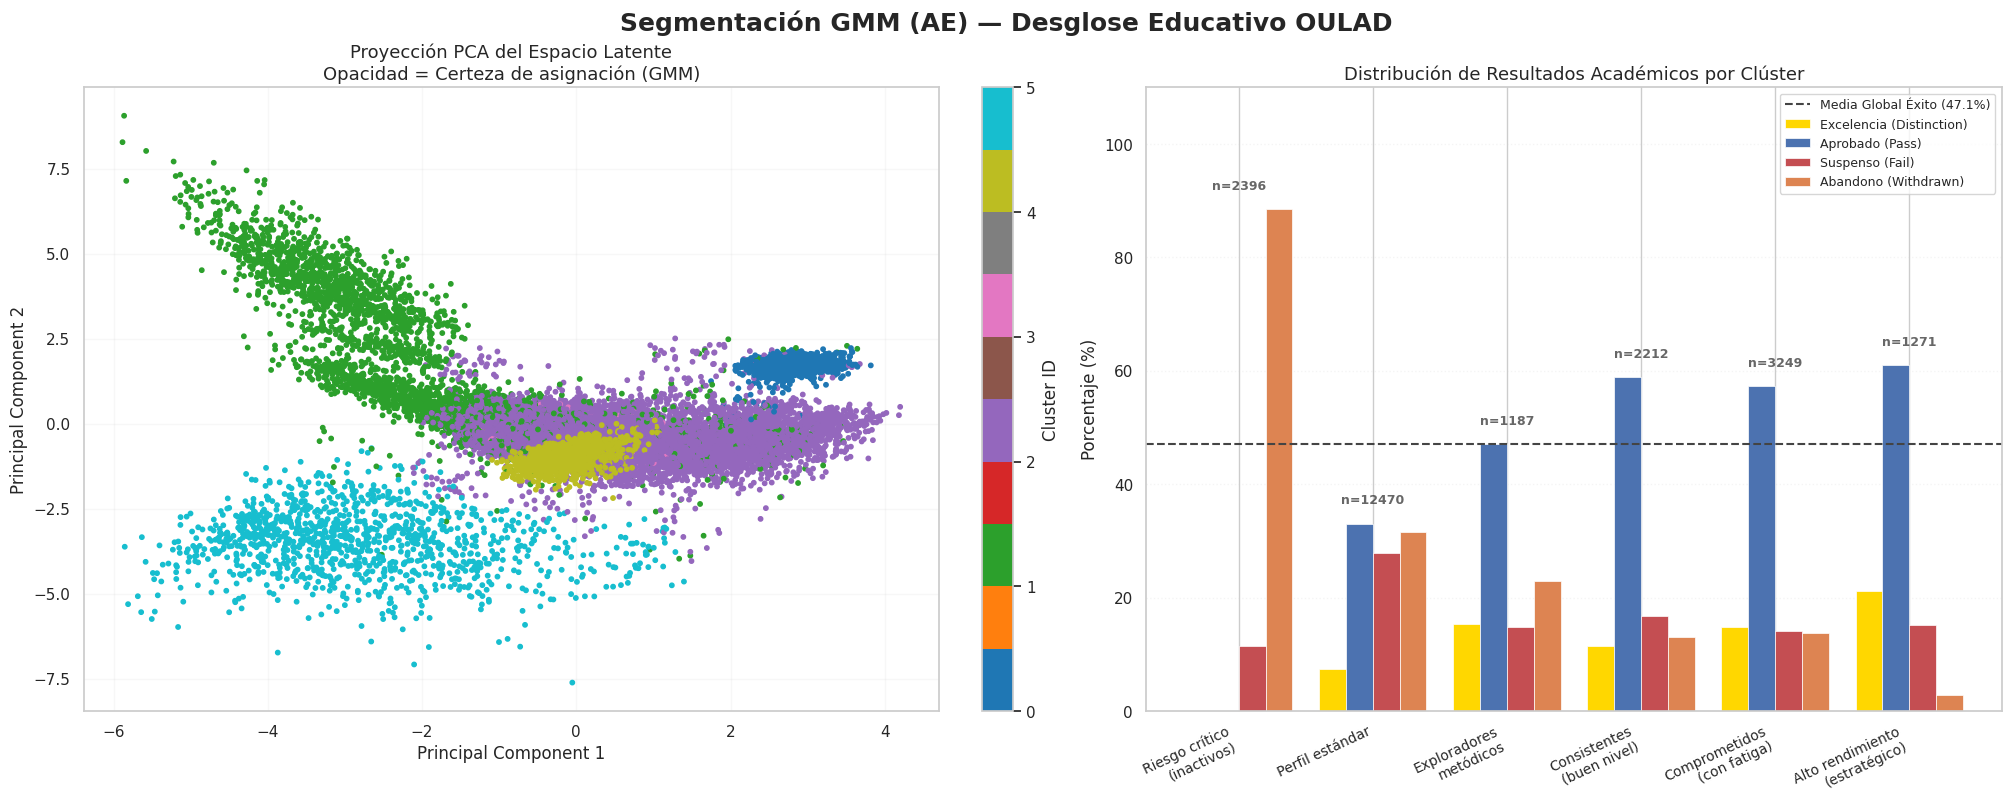

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Etiquetas cortas en español para los clústeres
label_es = {
    "CRITICAL_RISK_INACTIVE": "Riesgo crítico\n(inactivos)",
    "STANDARD_PROFILE": "Perfil estándar",
    "METHODICAL_EXPLORER": "Exploradores\nmetódicos",
    "CONSISTENT_GOOD": "Consistentes\n(buen nivel)",
    "ENGAGED_FATIGUE": "Comprometidos\n(con fatiga)",
    "STRATEGIC_HIGH_PERFORMER": "Alto rendimiento\n(estratégico)",
}

def plot_tutor_view_es_bars_oulad(
    X, df_seg,
    cluster_col="cluster_id",
    label_col="cluster_label",
    conf_col="confidence",
    success_col="is_success",
    result_col="actual_result_name",
    max_points=30000,
    seed=42,
    title="Segmentación GMM (AE) — Desglose Educativo OULAD"
):
    rng = np.random.RandomState(seed)
    df = df_seg.copy()

    # --- Gestión de confianza ---
    if conf_col in df.columns:
        conf = df[conf_col].astype(float).values
        if np.nanmax(conf) > 1.0:
            conf = conf / 100.0
    elif "confidence_pct" in df.columns:
        conf = df["confidence_pct"].astype(float).values / 100.0
    else:
        conf = np.ones(len(df), dtype=float)

    # --- Sampling para el Scatter ---
    n = X.shape[0]
    idx = rng.choice(np.arange(n), size=min(max_points, n), replace=False) if n > max_points else np.arange(n)
    Xs = X[idx]
    df_s = df.iloc[idx].copy()
    conf_s = conf[idx]

    # --- PCA 2D para visualización ---
    p2 = PCA(n_components=2, random_state=seed).fit_transform(Xs)

    # --- Métricas por clúster (Desglose 4 categorías) ---
    # Inicializamos el DataFrame de métricas
    agg = df.groupby([cluster_col, label_col]).agg(
        n=(success_col, "size"),
        success_rate=(success_col, "mean") # Para la línea de media global
    ).reset_index()

    # Categorías típicas de OULAD
    oulad_cats = ["Distinction", "Pass", "Fail", "Withdrawn"]
    
    if result_col in df.columns:
        for cat in oulad_cats:
            # Calculamos el % de cada categoría por cada grupo
            agg[f"{cat.lower()}_%"] = df.groupby([cluster_col, label_col])[result_col].apply(
                lambda s: 100 * (s == cat).mean()
            ).values
    else:
        # Fallback si no existe la columna de resultados
        for cat in oulad_cats: agg[f"{cat.lower()}_%"] = 0

    agg["label_es"] = agg[label_col].map(lambda x: label_es.get(x, str(x)))
    
    # Ordenar de peor a mejor por éxito acumulado (Distinction + Pass)
    agg["total_success"] = agg["distinction_%"] + agg["pass_%"]
    agg = agg.sort_values("total_success", ascending=True).reset_index(drop=True)

    global_success = 100 * df[success_col].mean()

    # =========================
    # PLOT (2 paneles)
    # =========================
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
    fig.suptitle(title, fontsize=18, fontweight='bold')

    # --- Panel A: PCA Scatter ---
    ax = axes[0]
    alphas = np.clip(0.15 + 0.85 * conf_s, 0.15, 1.0)
    sc = ax.scatter(p2[:, 0], p2[:, 1], c=df_s[cluster_col].values, s=10, cmap="tab10")
    
    colors = sc.get_facecolors()
    if len(colors) == len(alphas):
        colors[:, 3] = alphas
        sc.set_facecolors(colors)

    ax.set_title("Proyección PCA del Espacio Latente\nOpacidad = Certeza de asignación (GMM)", fontsize=13)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.grid(True, alpha=0.15)
    plt.colorbar(sc, ax=ax, label="Cluster ID")

    # --- Panel B: 4 Barras OULAD ---
    ax = axes[1]
    x = np.arange(len(agg))
    width = 0.20  # Ancho reducido para que quepan 4 barras juntas

    # Definición de colores y etiquetas para las barras
    # Usamos una paleta profesional: Oro para Distinción, Azul/Verde para Pass, Rojo para Fail, Naranja para Withdrawn
    bar_configs = [
        ("distinction_%", "Excelencia (Distinction)", "#FFD700"), # Gold
        ("pass_%", "Aprobado (Pass)", "#4C72B0"),               # Blue
        ("fail_%", "Suspenso (Fail)", "#C44E52"),               # Red
        ("withdrawn_%", "Abandono (Withdrawn)", "#DD8452"),     # Orange
    ]

    # Dibujamos cada set de barras con un pequeño offset
    offsets = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]
    
    for i, (col, label, color) in enumerate(bar_configs):
        ax.bar(x + offsets[i], agg[col].values, width=width, label=label, color=color, edgecolor='white', linewidth=0.5)

    # Línea de media global (%)
    ax.axhline(global_success, color="#444", linestyle="--", linewidth=1.5, 
               label=f"Media Global Éxito ({global_success:.1f}%)")

    ax.set_title("Distribución de Resultados Académicos por Clúster", fontsize=13)
    ax.set_ylabel("Porcentaje (%)")
    ax.set_ylim(0, 110) # Espacio extra para anotaciones
    ax.set_xticks(x)
    ax.set_xticklabels(agg["label_es"].values, rotation=25, ha="right", fontsize=10)
    ax.grid(True, axis="y", alpha=0.2, linestyle=':')
    ax.legend(loc='upper right', frameon=True, fontsize=9)

    # Anotar n total encima de cada grupo
    for i, n_i in enumerate(agg["n"].values):
        # Buscamos el valor más alto de las 4 barras para posicionar el texto
        y_max = max(agg["distinction_%"].iloc[i], agg["pass_%"].iloc[i], 
                    agg["fail_%"].iloc[i], agg["withdrawn_%"].iloc[i])
        ax.text(i, y_max + 3, f"n={int(n_i)}", ha="center", va="bottom", fontsize=9, fontweight='bold', alpha=0.7)

    plt.show()

# --- EJEMPLO DE USO ---
plot_tutor_view_es_bars_oulad(X_ae, df_final_segmentation)
